In [1]:
%matplotlib inline
import matplotlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
from scipy import ndimage
import os
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
from sklearn.utils import shuffle
import tensorflow.contrib.layers as layers
import tensorflow.contrib.slim as slim

In [2]:
imageset = np.empty((7704,64,64,3), dtype='float32')

#There are 7704 images in the dataset.
#214 folders. Each having 36 images.
rootdir = '/home/chinmay/CODE/deep_learning/shapenet_datasets/mug_unprocessed/mug/models/3dw'
cnt = 0
total_cnt = 0

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        filepath = subdir + os.sep + file
        if filepath.endswith('.png'):
            if cnt == 36:
                cnt = 0
                total_cnt += 1
            cnt += 1
            seq_number = int(filepath.split('-')[-1].split('.')[0])
            
            imageset[total_cnt*36 + seq_number] = misc.imread(filepath).astype(np.float32)

In [3]:
def get_train(data, pairs_per_model):
    W,H,C = 64,64,3
    images_per_model = 36
    pose_W, pose_H, pose_D = 8,8,36

    total_models = int(data.shape[0] / images_per_model)
    print(total_models)
    data_train = np.zeros((total_models * pairs_per_model, W,H,C))
    
    data_ = np.zeros((total_models * pairs_per_model,W,H,C))
    labels_ = np.zeros((total_models * pairs_per_model,W,H,C))
    pose = np.zeros((total_models * pairs_per_model,pose_W,pose_H,pose_D))
    
    for cnt in range(total_models ):
        tmp_data = np.zeros((images_per_model * images_per_model,W,H,C))
        tmp_labels = np.zeros((images_per_model * images_per_model,W,H,C))
        tmp_pose = np.zeros((images_per_model * images_per_model, pose_W,pose_H,pose_D))
        for i in range(images_per_model):
            for j in range(images_per_model):
                num = (j-i) % images_per_model
                pose_tmp = np.zeros(images_per_model)
                pose_tmp[num] = 1
                tmp_pose[i*images_per_model + j] = np.broadcast_to(pose_tmp,(pose_W,pose_H,pose_D))
                tmp_data[i*images_per_model + j] = data[cnt*images_per_model + i]
                tmp_labels[i*images_per_model + j] = data[cnt *images_per_model + j]         
        rand_nums = np.random.randint(0,images_per_model * images_per_model - 1,pairs_per_model)
        data_[cnt*pairs_per_model : (cnt+1)*pairs_per_model] = tmp_data[rand_nums]
        labels_[cnt*pairs_per_model : (cnt+1)*pairs_per_model] = tmp_labels[rand_nums]
        pose[cnt*pairs_per_model : (cnt+1)*pairs_per_model] = tmp_pose[rand_nums]
        
    data_, labels_, pose = shuffle(data_, labels_, pose, random_state=0)
    return data_, labels_, pose

In [4]:
data_, labels_, pose = get_train(imageset, 50)

214


In [5]:
print(data_.shape)
print(labels_.shape)
print(pose.shape)

(10700, 64, 64, 3)
(10700, 64, 64, 3)
(10700, 8, 8, 36)


In [6]:

'''
data_ = np.zeros(imageset.shape)
labels_ = np.zeros(imageset.shape)
pose = np.zeros((7704,8,8,36))

for cnt in range(214):
    for itr in range(36):
        data_[(cnt*36) + itr] = imageset[cnt*36]
        pose_tmp = np.zeros(36)
        pose_tmp[itr] = 1
        pose[(cnt*36) + itr] = np.broadcast_to(pose_tmp,(8,8,36))
        labels_[(cnt*36) + itr] =  imageset[(cnt*36) + itr]
        #print( (cnt*36) + itr)

data_, labels_, pose = shuffle(data_, labels_, pose, random_state=0)
#This code will generate labels for the dataset
#perm = np.random.permutation(data_.shape[0])

# data_ = data_[perm]
# labels_ = labels_[perm]
# pose = pose[perm]
'''
# For current image label is the next image (image with 10 degree rotation)
# For last image in the set (36th image) label would be first image
data_train = np.array(data_[:9000])
data_test = np.array(data_[9000:])

train_labels = np.array(labels_[:9000])
test_labels = np.array(labels_[9000:])

print(data_train.shape)
print(train_labels.shape)

(9000, 64, 64, 3)
(9000, 64, 64, 3)


[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


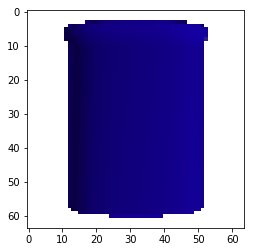

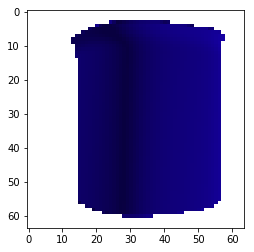

In [7]:
tmp = train_labels[16][...,::-1]
tmp1 = data_train[16][...,::-1]

print(pose[100][0][0])
plt.imshow(tmp1/255)
plt.show()
plt.imshow(tmp/255)
plt.show()

In [8]:
#normalize data


#data_train *= 2
data_train /= 255
#data_train -= 1

#data_test *= 2
data_test /= 255
#data_test -= 1


#train_labels *= 2
train_labels /= 255
#train_labels -= 1

#test_labels *= 2
test_labels /= 255
#test_labels -= 1

In [9]:
def conv2d(input, output, kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv2d", act=tf.nn.leaky_relu):
    #act = tf.nn.leaky_relu
    with tf.variable_scope(scope_name):
        return layers.conv2d(inputs=input, num_outputs=output, kernel_size=[kernel_h, kernel_w], stride=k_stride, activation_fn=act,
         biases_initializer=tf.zeros_initializer(), weights_initializer=tf.random_normal_initializer(0.0, 0.02))
    
def deconv2d(input, kernel_size, stride, num_filter, scope_name='deconv2d', act=tf.nn.leaky_relu):
    with tf.variable_scope(scope_name): 
        stride_shape = [stride, stride]
        kernel_shape = [kernel_size, kernel_size]
        return layers.conv2d_transpose(inputs=input, num_outputs=num_filter, stride=stride_shape, kernel_size= kernel_shape,
            padding='SAME', biases_initializer=tf.zeros_initializer(), weights_initializer=tf.random_normal_initializer(0.0, 0.02),
            activation_fn=act
        )

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')


def batch_norm(inputs_, is_training):
    out = tf.contrib.layers.batch_norm(inputs_, decay = 0.99, center = True, scale = True,
                                       is_training = is_training, updates_collections = None)
    return out

def fc(input, num_output, name = 'fc'):
    with tf.variable_scope(name):
        num_input = input.get_shape()[1]
        W = tf.get_variable('w', [num_input, num_output], tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [num_output], initializer = tf.constant_initializer(0.0))
        return tf.matmul(input, W) + b

def l1_loss(inputs_, targets_):
    loss = tf.reduce_mean(abs(inputs_ - targets_))
    return loss

def ce_loss(labels, logits):
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, logits = logits)
        return tf.reduce_mean(loss)
    

In [10]:
tf.reset_default_graph()
#to Reset Tensor Flow Graph

In [11]:
batch_size = 25
# tf Graph input (only pictures)
inputs_ = tf.placeholder(tf.float32, (batch_size, 64,64,3), name="input")
targets_ = tf.placeholder(tf.float32, (batch_size, 64,64,3), name="target")
pose_ = tf.placeholder(tf.float32, (batch_size, 8, 8, 36), name="pose")

disc_inputs = tf.placeholder(tf.float32, (batch_size, 64,64,3), name="input")

real_label = tf.placeholder(tf.float32, [batch_size, 1])
fake_label = tf.placeholder(tf.float32, [batch_size, 1])

In [12]:

#generate coarse images from inputs_
def auto_encoder(inputs_, pose_):
    print(inputs_)
    with tf.variable_scope('encoder'):
        _ = conv2d(inputs_, output=16 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv1",act=tf.nn.leaky_relu)
        _ = batch_norm(_, True)
        _ = conv2d(_, output=32 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv2",act=tf.nn.leaky_relu)
        _ = batch_norm(_, True)
        _ = conv2d(_, output=92 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv3",act=tf.nn.leaky_relu)
        _ = tf.concat([_, pose_], 3)

        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=32, scope_name='deconv1',act=tf.nn.leaky_relu)
        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=16, scope_name='deconv2',act=tf.nn.leaky_relu)
        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=3, scope_name='deconv3',act=tf.nn.leaky_relu)
        _ = tf.sigmoid(_)
    return _ 
    
    
# discriminator should give a fc layer
def discriminator(inputs_):
    with tf.variable_scope('dis', reuse = tf.AUTO_REUSE):
        ''' 
        _ = conv2d(inputs_, 4, 2, 32, 'conv1')
        _ = leaky_relu(_)
        _ = conv2d(_, 4, 2, 64, 'conv2')
        _ = batch_norm(_)
        _ = leaky_relu(_)
        _ = conv2d(_, 4, 2, 128, 'conv3')
        _ = batch_norm(_)
        _ = leaky_relu(_)
        _ = tf.reshape(_, [-1, 4 * 4 * 128])
        _ = fc(_, 1, 'fc4')
        print(_.get_shape(), "FC - Result")
        '''
        
        _ = conv2d(inputs_, output=16 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="dis_conv1", act=tf.nn.leaky_relu)
        _ = conv2d(_, output=32 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="dis_conv2", act=tf.nn.leaky_relu)
        _ = batch_norm(_, True)
        _ = conv2d(_, output=32 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="dis_conv3", act=tf.nn.leaky_relu)
        _ = batch_norm(_, True)
        _ = tf.reshape(_, [-1, 8 * 8 * 32])        
        _ = fc(_, 1, 'dis_fc1')
        return _
        
    

In [13]:

global_step = tf.Variable(0,trainable=False)
lr = 5e-4


In [14]:
alpha = 0.1
beta = 0.9

generated_images = auto_encoder(inputs_, pose_)
dis_fake_samples_op = discriminator(generated_images)

gen_loss_op = alpha * ce_loss(real_label, dis_fake_samples_op) + beta * l1_loss(generated_images, targets_)
dis_loss_op = ce_loss(fake_label, dis_fake_samples_op) + ce_loss(real_label, discriminator(disc_inputs))

 

Tensor("input:0", shape=(25, 64, 64, 3), dtype=float32)


In [15]:
disriminator_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
generator_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'encoder')
#print (generator_vars)
dis_optimizer = tf.train.RMSPropOptimizer(lr)
dis_train_op = dis_optimizer.minimize(dis_loss_op, var_list=disriminator_vars)

gen_optimizer = tf.train.RMSPropOptimizer(lr)
gen_train_op = gen_optimizer.minimize(gen_loss_op, var_list=generator_vars)

In [18]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

epochs = 50
total_images = 9000
step = 0

r = total_images // batch_size
#print(data_train.shape, "X1")
#d_inputs = data_train[399*batch_size : (400)*batch_size]
#print(d_inputs.shape, "X2")

for epoch in range(epochs):
    for ii in range(r):
        step += 1
        zeros = np.zeros([batch_size, 1])
        ones = np.ones([batch_size, 1])
        
        batch = data_train[ii*batch_size : (ii+1)*batch_size]
        batch_labels = train_labels[ii*batch_size : (ii+1)*batch_size]
        pose_labels = pose[ii*batch_size : (ii+1)*batch_size]
        #print(batch.shape, "BS")
        #print(batch_labels.shape, "LS")
        #print(pose_labels.shape)
        
        k = np.random.randint(1,r-1)
        #print("K", k)
        
        d_inputs = data_train[k*batch_size : (k+1)*batch_size]
        
        #print(d_inputs.shape, "DI", k)
        gen_feed_dict = {inputs_: batch, targets_: batch_labels, pose_: pose_labels,
                         real_label: ones}

        _, gen_loss = sess.run([gen_train_op, gen_loss_op], feed_dict = gen_feed_dict)
        
        
        dis_feed_dict = {inputs_: batch, targets_: batch_labels, pose_: pose_labels,
                         fake_label: zeros, real_label: ones, disc_inputs: d_inputs}

        _, dis_loss = sess.run([dis_train_op, dis_loss_op], feed_dict = dis_feed_dict)

        #if step % 10 == 0:
        #    print('Epoch {0}: dis loss = {1:.4f}, gen loss = {2:.4f}'.format(epoch, dis_loss, gen_loss))
            
    print('Epoch {0}: dis loss = {1:.4f}, gen loss = {2:.4f}'.format(epoch, dis_loss, gen_loss))


Epoch 0: dis loss = 1.1756, gen loss = 0.3930
Epoch 1: dis loss = 0.9858, gen loss = 0.2633
Epoch 2: dis loss = 0.9521, gen loss = 0.2686
Epoch 3: dis loss = 0.1491, gen loss = 0.6204
Epoch 4: dis loss = 0.4917, gen loss = 0.7616
Epoch 5: dis loss = 0.5520, gen loss = 0.6116
Epoch 6: dis loss = 0.3650, gen loss = 0.4395
Epoch 7: dis loss = 0.6677, gen loss = 0.5493
Epoch 8: dis loss = 0.7540, gen loss = 0.3337
Epoch 9: dis loss = 0.9926, gen loss = 0.3044
Epoch 10: dis loss = 1.4167, gen loss = 0.3063
Epoch 11: dis loss = 1.0680, gen loss = 0.2624
Epoch 12: dis loss = 1.2637, gen loss = 0.4141
Epoch 13: dis loss = 1.0946, gen loss = 0.2908
Epoch 14: dis loss = 0.9902, gen loss = 0.4255


KeyboardInterrupt: 

In [ ]:
dis_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
gen_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'encoder')
saver = tf.train.Saver(dis_var_list + gen_var_list)
saver.save(sess, 'model/gan1')

In [ ]:

feed_dict = {inputs_: data_test[100:125], targets_: test_labels[100:125], pose_: pose[6120+100:6120+136],
            }


op = sess.run([generated_images], feed_dict = feed_dict)

In [ ]:
feed_dict = {inputs_: data_test[500:536], targets_: test_labels[500:536], pose_:pose[6120+500:6120+536],
            }


op = sess.run([generated_images], feed_dict = feed_dict)

In [ ]:
print(len(op[0]))

In [ ]:
tmp = op[0][22]
print(tmp.shape)

#print(np.max(tmp), np.min(tmp))
plt.imshow(tmp)
plt.show()

In [ ]:
plt.imshow(test_labels[500:536][22])
plt.show()